<a href="https://colab.research.google.com/github/wfaquieri/NLP_with_python/blob/main/winiciusfaquieri_nlpwithpy_pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Disciplina de Processamento de Linguagem Natural com Python

Bem-vindo ao projeto de disciplina de **Processamento de Linguagem Natural com Python**. Ao longo das últimas aulas vimos uma série de aplicações que nos deram a amplitude de possibilidades em trabalhar com textos. Para tal, usamos diversas bibliotecas, onde as que mais se destacaram foram NLTK, SPACY e GENSIM.

Esse notebook servirá de guia para a execução de uma análise de tópicos completa, usando o algoritmo de LDA e recursos para interpretação dos resultados. Utilizaremos notícias da seção "Mercado" extraídas da Folha de S. Paulo no ano de 2016.  Complete a análise com os códigos que achar pertinente e responda as questões presentes no Moodle. Boa sorte!

## O Notebook

Nesse notebook, você será guiado pela análise de **Extração de Tópicos**. As seguintes tarefas serão realizadas


1.   Download dos dados provenientes do kaggle 
2.   Seleção dos dados relevantes para a nossa análise
3.   Instalação das principais ferramentas e importação de módulos
4.   Pré-processamento usando NLTK
5.   Pré-processamento usando Spacy
6.   Análise de tópicos usando LDA
7.   Análise de NER usando Spacy
8.   Visualização dos tópicos usando tokens e entidades.



## Instruções para baixar os dados

Para baixar os dados será necessário o uso do gerenciador de downloads da Kaggle. A Kaggle, uma subsidiária do grupo Alphabet (Google), é uma comunidade on-line de cientistas de dados e profissionais de aprendizado de máquina.

Para utilizar o gerenciador, será necessário criar uma conta no site Kaggle.com.
Com a conta criada, obtenha um token de acesso, no formato kaggle.json

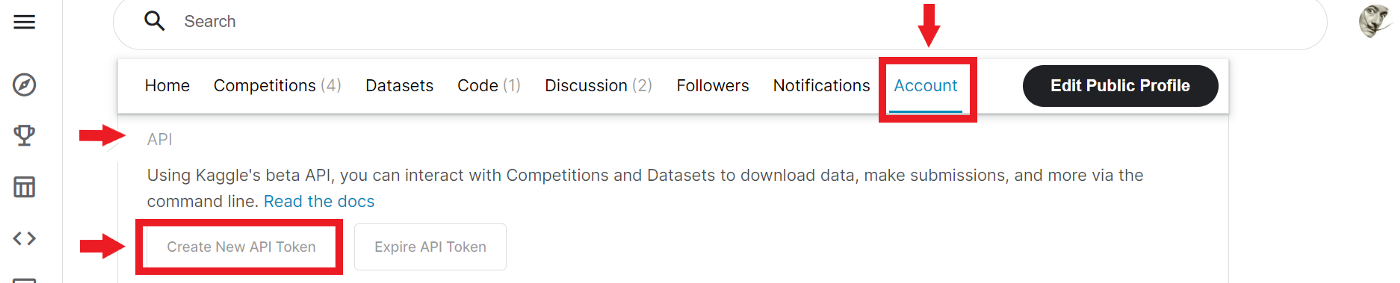

Em posse do token (baixe para seu computador), execute a células da próxima seção para acessar os dados de interesse e baixá-los.

# Baixe os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json 

In [2]:
!pip install -q kaggle
!rm -rf kaggle.json
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"winiciusfaquieri","key":"de0c802043fe6f165a2301693bdd5ec8"}'}

Crie a pasta .kaggle

In [3]:
!rm -rf .kaggle
!mkdir .kaggle
!cp kaggle.json .kaggle/
!chmod 600 .kaggle/kaggle.json

Baixe o dataset

In [4]:
!mv .kaggle /root/
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

 94% 176M/187M [00:01<00:00, 114MB/s]
100% 187M/187M [00:01<00:00, 124MB/s]


## Criar o DataFrame com os dados lidos diretamente da plataforma Kaggle

In [5]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

df = pd.read_csv("news-of-the-site-folhauol.zip")

In [46]:
## Visualizando o dataset
df.head()

Timestamp('2017-10-01 00:00:00')

Visualizando as categorias:
['poder' 'ilustrada' 'mercado' 'mundo' 'esporte' 'tec' 'cotidiano'
 'ambiente' 'equilibrioesaude' 'sobretudo' 'colunas' 'educacao' 'tv'
 'banco-de-dados' 'opiniao' 'ciencia' 'paineldoleitor' 'saopaulo'
 'ilustrissima' 'seminariosfolha' 'turismo' 'empreendedorsocial'
 'serafina' 'asmais' 'o-melhor-de-sao-paulo' 'bbc' 'comida' 'musica'
 'folhinha' 'especial' 'treinamento' 'multimidia' 'cenarios-2017'
 'topofmind' 'dw' 'ombudsman' 'contas-de-casa' 'mulher' '2016'
 'guia-de-livros-discos-filmes' 'treinamentocienciaesaude' 'rfi' 'vice'
 'bichos' 'euronews' 'guia-de-livros-filmes-discos' 'infograficos' '2015']


(-0.5, 799.5, 799.5, -0.5)

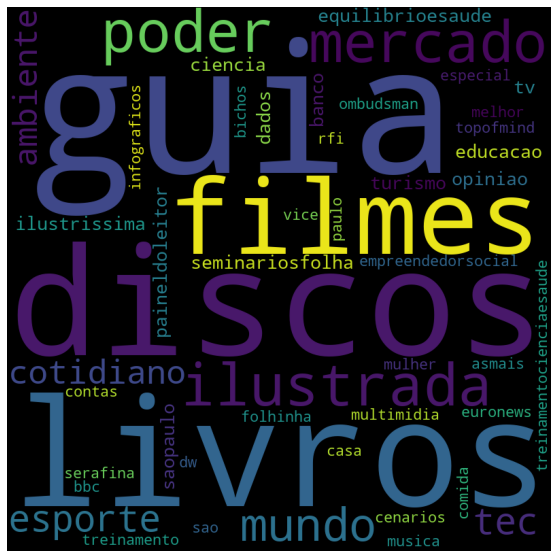

In [44]:
## Visualizando as categorias distintas
print('Visualizando as categorias:')
print(df.category.unique())

## Curiosidade: plotando uma nuvem de palavras com as categorias mais presentes na Folha de SP, entre 2015 e 2017. 
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
stopwords_pt = nltk.corpus.stopwords.words("portuguese")
stopwords_pt.extend(["sobretudo","colunas"])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
wordcloud = WordCloud(stopwords=stopwords_pt,
                      height=800,
                     width=800).generate(' '.join(df.category.unique()))
ax.imshow(wordcloud)
ax.axis("off")


In [13]:
## Otendo mais algumas informaçoes sobre o dataset

print('O datatset está bem preenchido, apenas a coluna subcategory apresenta uma percentagem alta de valores nulos:')
df.info()

O datatset está bem preenchido, apenas a coluna subcategory apresenta uma percentagem alta de valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167053 entries, 0 to 167052
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        167053 non-null  object
 1   text         166288 non-null  object
 2   date         167053 non-null  object
 3   category     167053 non-null  object
 4   subcategory  29635 non-null   object
 5   link         167053 non-null  object
dtypes: object(6)
memory usage: 7.6+ MB


# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

In [17]:
# Atualizando o spaCy e instalando o pipeline pt_core_news_lg (treinado para o idioma PT)
!pip install -U spacy 
!pip install tf-estimator-nightly # tensorflow requer tf-estimator-nightly.
!python -m spacy download pt_core_news_lg

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

     |████████████████████████████████| 568.2 MB 8.5 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

In [15]:
import nltk

# Instalando os datasets stopwords, punkt e rslp do nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download("rslp")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

## Carregar os módulos usados ao longo desse notebook

In [18]:
!pip install pyldavis &> /dev/null

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from typing import List, Set, Any


SEED = 123

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

Filtre os dados do DataFrame df e crie um DataFrame news_2016 que contenha apenas notícias de **2016** e da categoria **mercado**.

In [29]:
# Alterando o formato da data para datetime
df['date'] = pd.to_datetime(df.date)

# Criando um dataframe nomeado 'news_2016'
news_2016 = df.query('date >= "2016-01-01" and date <= "2016-12-31" and category == "mercado"')

display(news_2016) # 7943 rows × 6 columns # check rows, ok!

,title,text,date,category,subcategory,link
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
...,...,...,...,...,...,...
94280,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
94295,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
94301,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
94310,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...


## NLTK Tokenizer and Stemmer

Crie uma coluna no dataframe `news_2016` contendo os tokens para cada um dos textos. Os tokens devem estar representados pelo radical das palavras (stem). 
Para tal, complete o conteúdo da função `tokenize`.

In [52]:
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer

def tokenize(text: str) -> List:
  """
  Function for tokenizing using `nltk.tokenize.word_tokenize`
  
  Returns:
    - A list of stemmed tokens (`nltk.stem.RSLPStemmer`)
    IMPORTANT: Only tokens with alphabetic
               characters will be returned.
  """
  # text normalization
  tokens = nltk.word_tokenize(text)
  words  = [token for token in tokens if token.isalpha()]
  st = RSLPStemmer()
  stemmed_tokens = [st.stem(t) for t in words]
  return ' '.join(stemmed_tokens)

news_2016.loc[:, 'nltk_tokens'] = news_2016.text.progress_map(tokenize)

  0%|          | 0/7943 [00:00<?, ?it/s]

In [53]:
news_2016

,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,sou apen a mulh de um fazend diz christin cond...,"("", Sou, apenas, a, mulher, de, um, fazendeiro..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,a cont do celul ou control fic mais car a part...,"(A, conta, do, celular, pós-pago, ou, controle..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,a mai part do projet de ajust da cont públic a...,"(A, maior, parte, dos, projetos, de, ajuste, d..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,desd as prim déc do sécul se diz que as not de...,"(Desde, as, primeiras, décadas, do, século, 19..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,o cifr letr selec seman lanç na áre de negóci ...,"(O, Cifras, &, Letras, seleciona, semanalmente..."
...,...,...,...,...,...,...,...,...
94280,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,par o econom rodolf margat do banc santand a e...,"(Para, o, economista, Rodolfo, Margato, ,, do,..."
94295,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,conveni saúd boa form e praz as tend de consum...,"(Conveniência, ,, saúde, ,, boa, forma, e, pra..."
94301,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,com o rend em qued mais pesso são forç a busc ...,"(Com, o, rendimento, em, queda, ,, mais, pesso..."
94310,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,o brasil pod perd até milhã de vag com cart as...,"(O, Brasil, pode, perder, até, 2,2, milhões, d..."


## Criar uma documento SPACY para cada texto do dataset

Crie uma coluna `spacy_doc` que contenha os objetos spacy para cada texto do dataset de interesse. Para tal, carregue os modelos `pt_core_news_lg` e aplique em todos os textos (pode demorar alguns minutos...)

In [47]:
# Carregando o pipeline e aplicando para cada texto do dataset
nlp = spacy.load("pt_core_news_lg")
news_2016.loc[:, 'spacy_doc'] = news_2016.text.progress_map(nlp)

  0%|          | 0/7943 [00:00<?, ?it/s]

In [48]:
news_2016

,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,sou apen a mulh de um fazend diz christin cond...,"("", Sou, apenas, a, mulher, de, um, fazendeiro..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,a cont do celul ou control fic mais car a part...,"(A, conta, do, celular, pós-pago, ou, controle..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,a mai part do projet de ajust da cont públic a...,"(A, maior, parte, dos, projetos, de, ajuste, d..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,desd as prim déc do sécul se diz que as not de...,"(Desde, as, primeiras, décadas, do, século, 19..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,o cifr letr selec seman lanç na áre de negóci ...,"(O, Cifras, &, Letras, seleciona, semanalmente..."
...,...,...,...,...,...,...,...,...
94280,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,par o econom rodolf margat do banc santand a e...,"(Para, o, economista, Rodolfo, Margato, ,, do,..."
94295,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,conveni saúd boa form e praz as tend de consum...,"(Conveniência, ,, saúde, ,, boa, forma, e, pra..."
94301,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,com o rend em qued mais pesso são forç a busc ...,"(Com, o, rendimento, em, queda, ,, mais, pesso..."
94310,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,o brasil pod perd até milhã de vag com cart as...,"(O, Brasil, pode, perder, até, 2,2, milhões, d..."


## Realize a Lematização usando SPACY

O modelo NLP do spacy oferece a possiblidade de lematizar textos em português (o que não acontece com a biblioteca NLTK). Iremos criar uma lista de tokens
lematizados para cada texto do nosso dataset. Para tal, iremos retirar as 
stopwords, usando uma função que junta stopwords provenientes do NLTK e do Spacy. Essa lista completa, é retornada pela função stopwords (e você não precisa mexer).

Já a função filter retorna True caso o token seja composto por caracters alfabéticos, não estiver dentro da lista de stopwords e o lemma resultante não estiver contido na lista `o", "em", "em o", "em a" e "ano"`.

Crie uma coluna chamada `spacy_lemma` para armazenar o resultado desse pré-processamento.

In [ ]:
def stopwords() -> Set:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()

def filter(w: spacy.lang.pt.Portuguese) -> bool:
    """
    Filter stopwords and undesired tokens
    """
    # Escreva seu código aqui


def lemma(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """ 
    # Escreva seu cógigo aqui
    

news_2016.loc[:, 'spacy_lemma'] = news_2016.spacy_doc.progress_map(lemma)

## Reconhecimento de entidades nomeadas

Crie uma coluna `spacy_ner` que armazene todas as organizações (APENAS organizações) que estão contidas no texto.

In [ ]:
def NER(doc: spacy.lang.pt.Portuguese):
  """
  Return the list of organizations for a SPACY document
  """
  # Escreva seu código aqui

news_2016.loc[:, 'spacy_ner'] = news_2016.spacy_doc.progress_map(NER)

## Bag-of-Words

Crie uma coluna `tfidf` no dataframe `news_2016`. Use a coluna `spacy_lemma` como base para cálculo do TFIDF. 
O número máximo de features que iremos considerar é 5000. E o token, tem que ter aparecido pelo menos 10 vezes (`min_df`) nos documentos. 

In [ ]:
class Vectorizer:
  def __init__(self, doc_tokens: List):
    self.doc_tokens = doc_tokens
    self.tfidf = None

  
  def vectorizer(self):
      """
      Convert a list of tokens to tfidf vector
      Returns the tfidf vector and attribute it to self.tfidf
      """
      # Escreva seu código aqui
      #...
      # return ...

  def __call__(self):
    if self.tfidf is None:
        self.vectorizer()
    return self.tfidf

doc_tokens = news_2016.spacy_lemma.values.tolist()
vectorizer = Vectorizer(doc_tokens)

def tokens2tfidf(tokens):
    array =  vectorizer().transform([tokens]).toarray()[0]
    return array


news_2016.loc[:, 'tfidf'] = news_2016.spacy_lemma.progress_map(tokens2tfidf)

## Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

In [ ]:
N_TOKENS = 9

corpus = np.array(news_2016.tfidf.tolist())
#Escreva seu código aqui
#lda = ... (complete)

### Visualize os tópicos usando a ferramenta pyLDAVis

In [ ]:
# Escreva seu código aqui
# ...

### Atribua a cada text, um (e apenas um) tópic. 

Crie uma coluna `topic` onde o valor é exatamente o tópico que melhor caracteriza o documento de acordo com o algoritmo de LDA.

In [ ]:
def get_topic(tfidf: np.array):
    """
    Get topic for a lda trained model
    """
    # Escreva seu código aqui

news_2016['topic'] = news_2016.tfidf.progress_map(get_topic)

## Número de documentos vs tópicos 

Esse gráfico nos mostra quantos documentos foram caracterizados por cada tópico.

In [ ]:
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

## Crie uma nuvem de palavra para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa. 

In [ ]:
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot the wordcloud for the text/
    Arguments:
        -  text: string to be analised
        -  ax: plt subaxis
    Returns:
     - ax
    """
    # Escreva seu código aqui
    # return ax
    
def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

## Crie uma nuvem de entidades para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa. 

In [ ]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()